# Predicting the Winning Football Team

Can we design a predictive model capable of accurately predicting if the home team will win a football match? 

![alt text](https://6544-presscdn-0-22-pagely.netdna-ssl.com/wp-content/uploads/2017/04/English-Premier-League.jpg "Logo Title Text 1")

## Steps

1. We will clean our dataset
2. Split it into training and testing data (12 features & 1 target (winning team (Home/Away/Draw))
3. Train 3 different classifiers on the data 
  -Logistic Regression
  -Support Vector Machine 
  -XGBoost
4. Use the best Classifer to predict who will win given an away team and a home team

## History

Sports betting is a 500 billion dollar market (Sydney Herald)

![alt text](https://static1.squarespace.com/static/506a95bbc4aa0491a951c141/t/51a55d97e4b00f4428967e64/1369791896526/sports-620x349.jpg "Logo Title Text 1")

Kaggle hosts a yearly competiton called March Madness 

https://www.kaggle.com/c/march-machine-learning-mania-2017/kernels

Several Papers on this 

https://arxiv.org/pdf/1511.05837.pdf

"It is possible to predict the winner of English county twenty twenty cricket games in almost two thirds of instances."

https://arxiv.org/pdf/1411.1243.pdf

"Something that becomes clear from the results is that Twitter contains enough information to be useful for
predicting outcomes in the Premier League"

https://qz.com/233830/world-cup-germany-argentina-predictions-microsoft/

For the 2014 World Cup, Bing correctly predicted the outcomes for all of the 15 games in the knockout round.

So the right questions to ask are

-What model should we use?
-What are the features (the aspects of a game) that matter the most to predicting a team win? Does being the home team give a team the advantage? 

## Dataset

- Football is played by 250 million players in over 200 countries (most popular sport globally)
- The English Premier League is the most popular domestic team in the world
- Retrived dataset from http://football-data.co.uk/data.php

![alt text](http://i.imgur.com/YRIctyo.png "Logo Title Text 1")

- Football is a team sport, a cheering crowd helps morale
- Familarity with pitch and weather conditions helps
- No need to travel (less fatigue)

Acrononyms- https://rstudio-pubs-static.s3.amazonaws.com/179121_70eb412bbe6c4a55837f2439e5ae6d4e.html

## Other repositories

- https://github.com/rsibi/epl-prediction-2017 (EPL prediction)
- https://github.com/adeshpande3/March-Madness-2017 (NCAA prediction)

## Import Dependencies

In [ ]:
#data preprocessing
import pandas as pd
#produces a prediction model in the form of an ensemble of weak prediction models, typically decision tree
import xgboost as xgb
#the outcome (dependent variable) has only a limited number of possible values. 
#Logistic Regression is used when response variable is categorical in nature.
from sklearn.linear_model import LogisticRegression
#A random forest is a meta estimator that fits a number of decision tree classifiers 
#on various sub-samples of the dataset and use averaging to improve the predictive 
#accuracy and control over-fitting.
from sklearn.ensemble import RandomForestClassifier
#a discriminative classifier formally defined by a separating hyperplane.
from sklearn.svm import SVC
#displayd data
from IPython.display import display
%matplotlib inline

In [2]:
# Read data and drop redundant column.
data = pd.read_csv('final_dataset.csv')

# Preview data.
display(data.head())


#Full Time Result (H=Home Win, D=Draw, A=Away Win)
#HTGD - Home team goal difference
#ATGD - away team goal difference
#HTP - Home team points
#ATP - Away team points
#DiffFormPts Diff in points
#DiffLP - Differnece in last years prediction

#Input - 12 other features (fouls, shots, goals, misses,corners, red card, yellow cards)
#Output - Full Time Result (H=Home Win, D=Draw, A=Away Win) 

,FTR,HTP,ATP,HM1,HM2,HM3,AM1,AM2,AM3,HTGD,ATGD,DiffFormPts,DiffLP
30,H,1.25,1.00,D,D,W,D,W,L,0.50,0.25,0.25,-16.0
31,NH,0.75,0.25,L,L,W,D,L,L,-0.50,-0.75,0.50,-2.0
32,H,1.00,1.00,L,D,W,D,W,L,0.00,0.25,0.00,-3.0
33,NH,0.75,0.50,L,L,W,D,L,D,-0.25,-0.25,0.25,3.0
34,NH,1.00,1.50,D,L,W,W,W,L,0.00,0.75,-0.50,3.0


## Data Exploration

In [3]:
#what is the win rate for the home team?

# Total number of matches.
n_matches = data.shape[0]

# Calculate number of features. -1 because we are saving one as the target variable (win/lose/draw)
n_features = data.shape[1] - 1

# Calculate matches won by home team.
n_homewins = len(data[data.FTR == 'H'])

# Calculate win rate for home team.
win_rate = (float(n_homewins) / (n_matches)) * 100

# Print the results
print "Total number of matches: {}".format(n_matches)
print "Number of features: {}".format(n_features)
print "Number of matches won by home team: {}".format(n_homewins)
print "Win rate of home team: {:.2f}%".format(win_rate)

Total number of matches: 5600
Number of features: 12
Number of matches won by home team: 2603
Win rate of home team: 46.48%


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000003A7BA90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000000C4053C8>]], dtype=object)

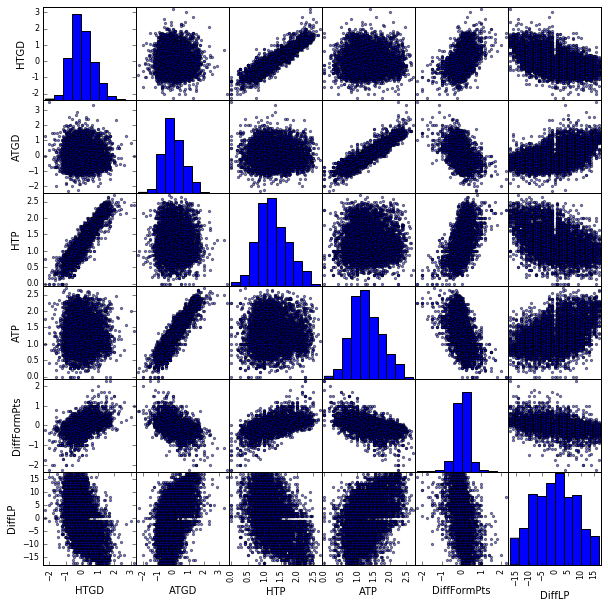

In [4]:
# Visualising distribution of data
from pandas.tools.plotting import scatter_matrix

#the scatter matrix is plotting each of the columns specified against each other column.
#You would have observed that the diagonal graph is defined as a histogram, which means that in the 
#section of the plot matrix where the variable is against itself, a histogram is plotted.

#Scatter plots show how much one variable is affected by another. 
#The relationship between two variables is called their correlation
#negative vs positive correlation

#HTGD - Home team goal difference
#ATGD - away team goal difference
#HTP - Home team points
#ATP - Away team points
#DiffFormPts Diff in points
#DiffLP - Differnece in last years prediction

scatter_matrix(data[['HTGD','ATGD','HTP','ATP','DiffFormPts','DiffLP']], figsize=(10,10))

## Preparing the Data

In [5]:
# Separate into feature set and target variable
#FTR = Full Time Result (H=Home Win, D=Draw, A=Away Win)
X_all = data.drop(['FTR'],1)
y_all = data['FTR']

# Standardising the data.
from sklearn.preprocessing import scale

#Center to the mean and component wise scale to unit variance.
cols = [['HTGD','ATGD','HTP','ATP','DiffLP']]
for col in cols:
    X_all[col] = scale(X_all[col])
    

In [6]:
#last 3 wins for both sides
X_all.HM1 = X_all.HM1.astype('str')
X_all.HM2 = X_all.HM2.astype('str')
X_all.HM3 = X_all.HM3.astype('str')
X_all.AM1 = X_all.AM1.astype('str')
X_all.AM2 = X_all.AM2.astype('str')
X_all.AM3 = X_all.AM3.astype('str')

#we want continous vars that are integers for our input data, so lets remove any categorical vars
def preprocess_features(X):
    ''' Preprocesses the football data and converts catagorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix = col)
                    
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

X_all = preprocess_features(X_all)
print "Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns))

Processed feature columns (24 total features):
['HTP', 'ATP', 'HM1_D', 'HM1_L', 'HM1_W', 'HM2_D', 'HM2_L', 'HM2_W', 'HM3_D', 'HM3_L', 'HM3_W', 'AM1_D', 'AM1_L', 'AM1_W', 'AM2_D', 'AM2_L', 'AM2_W', 'AM3_D', 'AM3_L', 'AM3_W', 'HTGD', 'ATGD', 'DiffFormPts', 'DiffLP']


In [7]:
# Show the feature information by printing the first five rows
print "\nFeature values:"
display(X_all.head())


Feature values:


,HTP,ATP,HM1_D,HM1_L,HM1_W,HM2_D,HM2_L,HM2_W,HM3_D,HM3_L,...,AM2_D,AM2_L,AM2_W,AM3_D,AM3_L,AM3_W,HTGD,ATGD,DiffFormPts,DiffLP
30,-0.043829,-0.611968,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.753719,0.355995,0.25,-1.989216
31,-1.120644,-2.238746,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,-0.737082,-1.138834,0.50,-0.248963
32,-0.582236,-0.611968,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.008318,0.355995,0.00,-0.373267
33,-1.120644,-1.696487,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,-0.364382,-0.391419,0.25,0.372556
34,-0.582236,0.472551,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.008318,1.103409,-0.50,0.372556


In [8]:
from sklearn.cross_validation import train_test_split

# Shuffle and split the dataset into training and testing set.
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, 
                                                    test_size = 50,
                                                    random_state = 2,
                                                    stratify = y_all)


## Training and Evaluating Models

In [9]:
#for measuring training time
from time import time 
# F1 score (also F-score or F-measure) is a measure of a test's accuracy. 
#It considers both the precision p and the recall r of the test to compute 
#the score: p is the number of correct positive results divided by the number of 
#all positive results, and r is the number of correct positive results divided by 
#the number of positive results that should have been returned. The F1 score can be 
#interpreted as a weighted average of the precision and recall, where an F1 score 
#reaches its best value at 1 and worst at 0.
from sklearn.metrics import f1_score

def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print "Trained model in {:.4f} seconds".format(end - start)

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    
    end = time()
    # Print and return results
    print "Made predictions in {:.4f} seconds.".format(end - start)
    
    return f1_score(target, y_pred, pos_label='H'), sum(target == y_pred) / float(len(y_pred))


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print "Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    f1, acc = predict_labels(clf, X_train, y_train)
    print f1, acc
    print "F1 score and accuracy score for training set: {:.4f} , {:.4f}.".format(f1 , acc)
    
    f1, acc = predict_labels(clf, X_test, y_test)
    print "F1 score and accuracy score for test set: {:.4f} , {:.4f}.".format(f1 , acc)

Logistic Regression

![alt text](https://image.slidesharecdn.com/logisticregression-predictingthechancesofcoronaryheartdisease-091203130638-phpapp01/95/logistic-regression-predicting-the-chances-of-coronary-heart-disease-2-728.jpg?cb=1259845609"Logo Title Text 1")

![alt text](https://i.ytimg.com/vi/HdB-z0TJRK4/maxresdefault.jpg "Logo Title Text 1")

Support Vector Machine

![alt text](https://image.slidesharecdn.com/supportvectormachine-121112135318-phpapp01/95/support-vector-machine-3-638.jpg?cb=1352729591 "Logo Title Text 1")
![alt text](http://docs.opencv.org/2.4/_images/optimal-hyperplane.png "Logo Title Text 1")

XGBoost

![alt text](https://raw.githubusercontent.com/dmlc/web-data/master/xgboost/model/cart.png "Logo Title Text 1")

![alt text](https://raw.githubusercontent.com/dmlc/web-data/master/xgboost/model/twocart.png "Logo Title Text 1")

![alt text](https://image.slidesharecdn.com/0782ee51-165d-4e34-a09c-2b7f8dacff01-150403064822-conversion-gate01/95/feature-importance-analysis-with-xgboost-in-tax-audit-17-638.jpg?cb=1450092771 "Logo Title Text 1")

![alt text](https://image.slidesharecdn.com/0782ee51-165d-4e34-a09c-2b7f8dacff01-150403064822-conversion-gate01/95/feature-importance-analysis-with-xgboost-in-tax-audit-18-638.jpg?cb=1450092771 "Logo Title Text 1")

In [10]:
# Initialize the three models (XGBoost is initialized later)
clf_A = LogisticRegression(random_state = 42)
clf_B = SVC(random_state = 912, kernel='rbf')
#Boosting refers to this general problem of producing a very accurate prediction rule 
#by combining rough and moderately inaccurate rules-of-thumb
clf_C = xgb.XGBClassifier(seed = 82)

train_predict(clf_A, X_train, y_train, X_test, y_test)
print ''
train_predict(clf_B, X_train, y_train, X_test, y_test)
print ''
train_predict(clf_C, X_train, y_train, X_test, y_test)
print ''

Training a LogisticRegression using a training set size of 5550. . .
Trained model in 0.2450 seconds
Made predictions in 0.0380 seconds.
0.621561035256 0.665405405405
F1 score and accuracy score for training set: 0.6216 , 0.6654.
Made predictions in 0.0000 seconds.
F1 score and accuracy score for test set: 0.6957 , 0.7200.

Training a SVC using a training set size of 5550. . .
Trained model in 2.5040 seconds
Made predictions in 1.2430 seconds.
0.620453572957 0.68036036036
F1 score and accuracy score for training set: 0.6205 , 0.6804.
Made predictions in 0.0250 seconds.
F1 score and accuracy score for test set: 0.6818 , 0.7200.

Training a XGBClassifier using a training set size of 5550. . .
Trained model in 0.4470 seconds
Made predictions in 0.0160 seconds.
0.652147113211 0.694954954955
F1 score and accuracy score for training set: 0.6521 , 0.6950.
Made predictions in 0.0020 seconds.
F1 score and accuracy score for test set: 0.7451 , 0.7400.



**Clearly XGBoost seems like the best model as it has the highest F1 score and accuracy score on the test set.**

# Tuning the parameters of XGBoost.

![alt text](https://i.stack.imgur.com/9GgQK.jpg "Logo Title Text 1")

In [39]:
# TODO: Import 'GridSearchCV' and 'make_scorer'
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer


# TODO: Create the parameters list you wish to tune
parameters = { 'learning_rate' : [0.1],
               'n_estimators' : [40],
               'max_depth': [3],
               'min_child_weight': [3],
               'gamma':[0.4],
               'subsample' : [0.8],
               'colsample_bytree' : [0.8],
               'scale_pos_weight' : [1],
               'reg_alpha':[1e-5]
             }  

# TODO: Initialize the classifier
clf = xgb.XGBClassifier(seed=2)

# TODO: Make an f1 scoring function using 'make_scorer' 
f1_scorer = make_scorer(f1_score,pos_label='H')

# TODO: Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj = GridSearchCV(clf,
                        scoring=f1_scorer,
                        param_grid=parameters,
                        cv=5)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_obj = grid_obj.fit(X_train,y_train)

# Get the estimator
clf = grid_obj.best_estimator_
print clf

# Report the final F1 score for training and testing after parameter tuning
f1, acc = predict_labels(clf, X_train, y_train)
print "F1 score and accuracy score for training set: {:.4f} , {:.4f}.".format(f1 , acc)
    
f1, acc = predict_labels(clf, X_test, y_test)
print "F1 score and accuracy score for test set: {:.4f} , {:.4f}.".format(f1 , acc)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0.4, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=3, missing=None, n_estimators=40, nthread=-1,
       objective='binary:logistic', reg_alpha=1e-05, reg_lambda=1,
       scale_pos_weight=1, seed=2, silent=True, subsample=0.8)
Made predictions in 0.0150 seconds.
F1 score and accuracy score for training set: 0.6365 , 0.6827.
Made predictions in 0.0000 seconds.
F1 score and accuracy score for test set: 0.7826 , 0.8000.


In [ ]:
#prediction

Possible Improvements?

-Adding Sentiment from Twitter, News Articles
-More features from other data sources (how much did others bet, player specific health stats)
